In [21]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torchvision
from torchvision import transforms, utils, datasets

import matplotlib.pyplot as plt


In [22]:
num_epochs = 30
batch_size = 64
learning_rate = 1e-3
n_anomalies= 5  # number of top anomalies
MODEL_TRAINED = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The variable n_anomalies can be changed to show any number of anomalies, according to the user's preference. 
MODEL_TRAINED can be changed to True if the model has already been trained, for faster re-runs. 
The device variable will be "cuda" if the cuda package was installed with pytorch, or "cpu", otherwise. 

In [23]:
def image_loader(path, batch_size=batch_size, shuffle=False):
    transform = transforms.Compose([
                transforms.Resize((148,148)),  # Resize the images to (148,148)
                transforms.ToTensor(),  # convert from numpy images to torch images
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize the images in the [-1,1] range
    ]) 
    image_set = datasets.ImageFolder(root=path, transform=transform)
    image_set_loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size, shuffle=shuffle, num_workers=4)

    return image_set_loader

I resized the images to (148,148), normalized them in the [-1, 1] range and converted them from numpy images to torch images. All these modifications were implemented in the Compose function. Moreover, I didn't shuffle the images to keep the images' index for plotting reasons

In [24]:
PATH_DATASET = "./lenses"
image_set_loader = image_loader(PATH_DATASET)  # create the DataLoader

The PATH_DATASET variable should be changed with the current location of the dataset. 

In [25]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(  # encoder - used for learning purposes
            nn.Conv2d(3, 62, 3, stride=3, padding=1),  # 1 st hidden layer
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # 2nd hidden layer
            nn.Conv2d(62, 31, 3, stride=2, padding=1),  # 3rd hidden layer
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # 4th hidden layer
        )
        self.decoder = nn.Sequential(  # decoder - used for reconstructing the image
            nn.ConvTranspose2d(31, 62, 3, stride=2),  # 5th hidden layer
            nn.ReLU(True),
            nn.ConvTranspose2d(62, 31, 5, stride=3, padding=1),  # 6th hidden layer
            nn.ReLU(True),
            nn.ConvTranspose2d(31, 3, 2, stride=2, padding=1),  # 7th hidden layer
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


To solve the anomaly detection problem in the given dataset, I used a convolutional neural network with an autoencoder. The model has two stages: the first one in which the images are encoded for learning purposes, and the second one in which the images are decoded for reconstruction. The main idea of an autoencoder in the anomaly detection problem is to reconstruct the initial image and calculate the corresponding error. The images with the highest error will be considered anomalies. In order to detect anomalies one can either set a threshold for the error function, thus everything above that threshold is considered anomaly, or pick the n biggest errors and categorise them as anomalies. I have used the latter approch. 

For the encoder, a sequential container was used with Conv2d as the convolutional layers, ReLU as the activation functions and  MaxPool2d as dimensionality reduction layers. 

For the decoder, the above statements were reverted, using the ConvTranspose2d as the "deconvolution" function, ReLU as activation function and, in the end, the Tanh function was applied at the output.


In [26]:
if MODEL_TRAINED == False:
    model = AutoEncoder().to(device, non_blocking=True)  # create the model
    error_function = nn.MSELoss()  # mean squared error function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)  # adam optimizer
    for epoch in range(num_epochs):  
        for data in image_set_loader:
            img, labels = data
            img = Variable(img).to(device, non_blocking=True)
            # forward propagation
            output = model(img)
            loss = error_function(output, img)
            # backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # log
        print('epoch [{}/{}], loss:{:.4f}'
            .format(epoch+1, num_epochs, loss.item()))

For the training part, the considered loss function for the created model was mean squared error from the torch.nn library. The chosen optimizer was Adam with standard model parameters, learning rate of 1e-3 and weight decay of 1e-5.  

In [27]:
if MODEL_TRAINED == False:  # save the trained model
    PATH = './cnn_model.pth'
    torch.save(model.state_dict(), PATH)

In [28]:
if MODEL_TRAINED == True:  # load the trained model
    PATH = './cnn_model.pth'
    model=AutoEncoder().to(device, non_blocking=True)
    model.load_state_dict(torch.load(PATH))

In [29]:
list_max_error = list()
for batch_id, data in enumerate(image_set_loader):
  X, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)  # get the image
  Y = model(X)  # reconstruct the image
  N = len(X)
  max_error = 0.0
  for i in range(N):
    curr_error = torch.sum((X[i]-Y[i])*(X[i]-Y[i]))  # calculate the error
    if curr_error.item() > max_error:
      max_error = curr_error.item()
  list_max_error.append(max_error)  # create a list with all the errors for each image
list_max_error = sorted(range(len(list_max_error)), key=lambda i: list_max_error[i])[-n_anomalies:]  # sort the images in descending order and pick the first n_anomalies

print(list_max_error)


[77, 144, 146, 18, 6]


In the above block the reconstruction takes part. Therefore, the error between the input image and the reconstructed one is calculated, the biggest n values being stored in list_max_error. 

In the below section the images considered anomalies are plotted. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
One of the highest reconstruction error has the index  6
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
One of the highest reconstruction error has the index  18
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
One of the highest reconstruction error has the index  77
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RG

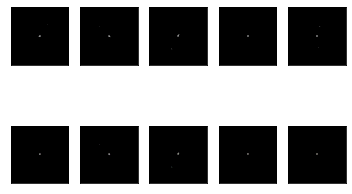

In [30]:
i = 1
for batch_id, data in enumerate(image_set_loader):
  X, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True) # get the image 
  Y = model(X)  # reconstruct the image
  if batch_id in list_max_error:
    print("One of the highest reconstruction error has the index ", batch_id)
    ax = plt.subplot(2,n_anomalies,i)  # plot the first n_anomalies
    plt.imshow(X[0].cpu().permute(2,1,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2,n_anomalies,i + n_anomalies)
    plt.imshow(Y[0].cpu().detach().numpy().transpose(2,1,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1 
